In [2]:
%%time
import configparser
config = configparser.ConfigParser()
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
 

TICKERS = ['EUR/USD']
x = TICKERS[0]
config.read('config.ini')
_period1 = config.get('TIMEFRAME','_period1')
_path4 = config.get('PATH','_path4')
_path = _path4
config['PATH']['_path'] = _path
with open('config.ini', 'w') as configfile: # save
    config.write(configfile)

globals()['df1_%s' %x.replace('/','')] = pd.read_csv(_path+x.replace('/','')+_period1+'.csv')

df = globals()['df1_%s' %x.replace('/','')].copy()

try:
    df = df.drop(['Unnamed: 0'],axis=1)
except:
    pass

BUY = []
SELL = []
for i in range(len(df)):
    if df.Signal[i] == 1:
        BUY.append(1)
        SELL.append(0)
    elif df.Signal[i] == -1:
        BUY.append(0)
        SELL.append(1)
    else:
        BUY.append(0)
        SELL.append(0)
df['Buy'] = BUY
df['Sell'] = SELL
df = df.drop(['Date','Total','Signal'],axis=1)

X = df.iloc[:,:-2]

yb = df['Buy']
yv = df['Sell']
# summarize class distribution
counterb = Counter(yb)
counterv = Counter(yv)
print('Signaux achat avant oversampling',counterb)
print('Signaux vente avant oversampling',counterv)

oversample = SMOTE(sampling_strategy=0.5)

Xb_over, yb_over = oversample.fit_resample(X, yb)
Xv_over, yv_over = oversample.fit_resample(X, yv)

print('Signaux achat après oversampling',Counter(yb_over))
print('Signaux vente après oversampling',Counter(yv_over))

# split into train/test sets with same class ratio
trainXb, testXb, trainyb, testyb = train_test_split(Xb_over, yb_over, test_size=0.5, stratify=yb_over)
trainXv, testXv, trainyv, testyv = train_test_split(Xv_over, yv_over, test_size=0.5, stratify=yv_over)
# define model
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# fit model
model.fit(trainXb, trainyb)
# predict on test set
yhatb = model.predict(testXb)
# evaluate predictions
print('Achat - Accuracy: %.3f' % accuracy_score(testyb, yhatb))
print('Achat - Precision: %.3f' % precision_score(testyb, yhatb))
print('Achat - Recall: %.3f' % recall_score(testyb, yhatb))
print('Achat - F-measure: %.3f' % f1_score(testyb, yhatb))

fprb, tprb, thresholdsb = roc_curve(testyb, yhatb)
# calculate the g-mean for each threshold
gmeansb = sqrt(tprb * (1-fprb))
# locate the index of the largest g-mean
ixb = argmax(gmeansb)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsb[ixb], gmeansb[ixb]))
# plot the roc curve for the model
plt.figure(figsize=(12,4))
plt.suptitle('ROC Curve pour les achats')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fprb, tprb, marker='.', label='Logistic')
plt.scatter(fprb[ixb], tprb[ixb], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

model.fit(trainXv, trainyv)
# predict on test set
yhatv = model.predict(testXv)
# evaluate predictions
print('Vente - Accuracy: %.3f' % accuracy_score(testyv, yhatv))
print('Vente - Precision: %.3f' % precision_score(testyv, yhatv))
print('Vente - Recall: %.3f' % recall_score(testyv, yhatv))
print('Vente - F-measure: %.3f' % f1_score(testyv, yhatv))

fprv, tprv, thresholdsv = roc_curve(testyv, yhatv)
# calculate the g-mean for each threshold
gmeansv = sqrt(tprv * (1-fprv))
# locate the index of the largest g-mean
ixv = argmax(gmeansv)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsv[ixv], gmeansv[ixv]))
# plot the roc curve for the model
plt.figure(figsize=(12,4))
plt.suptitle('ROC Curve pour les ventes')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fprv, tprv, marker='.', label='Logistic')
plt.scatter(fprv[ixv], tprv[ixv], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
# plot the roc curve for the model
no_skillb= len(testyb[testyb==1]) / len(testyb)

# convert to f score
fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
# locate the index of the largest f score
ixb = argmax(fscoreb)
print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))

plt.figure(figsize=(12,4))
plt.suptitle('Recall_Precision Curve pour les achats')
plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
plt.plot(recallb, precisionb, marker='.', label='Logistic')
plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

precisionv, recallv, thresholdsv = precision_recall_curve(testyv, yhatv)
# plot the roc curve for the model
no_skillv= len(testyv[testyv==1]) / len(testyv)

# convert to f score
fscorev = (2 * precisionv * recallv) / (precisionv + recallv)
# locate the index of the largest f score
ixv = argmax(fscorev)
print('Best Threshold=%f, F-Score=%.3f' % (thresholdsv[ixv], fscorev[ixv]))

plt.figure(figsize=(12,4))
plt.suptitle('Recall_Precision Curve pour les ventes')
plt.plot([0,1], [no_skillv,no_skillv], linestyle='--', label='No Skill')
plt.plot(recallv, precisionv, marker='.', label='Logistic')
plt.scatter(recallv[ixv], precisionv[ixv], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()


KeyError: "['Total'] not found in axis"

In [ ]:

################################


In [ ]:
import time
import pandas as pd


In [ ]:
%%time
df = pd.read_csv('Base_Signals/AUDCHFm5.csv')
df.head(1)

In [ ]:
%%time
df_buy = df[df.Signal==1]
df_sell = df[df.Signal==-1]

In [ ]:
%%time
BUY = []
_target = 0.0020
_sl = 0.0090
_spread_filter = 0.00050
for date in df_buy.Date:
    if float(df_buy[df.Date == date].CloseBid.values)*(1+_target) <= \
                df.iloc[df.index[df[df.Date == date].index[0]]:df.index[df[df.Date == date].index[0]]+5,:].HighBid.max():
        BUY.append(1)
    else:
        BUY.append(0)
len(BUY),len(df_buy) 

In [ ]:
%%time
SELL = []
_target = 0.0020
_sl = 0.0090
_spread_filter = 0.00050
for date in df_sell.Date:
    if float(df_sell[df.Date == date].CloseAsk.values)*(1-_target) >= \
                df.iloc[df.index[df[df.Date == date].index[0]]:df.index[df[df.Date == date].index[0]]+5,:].LowBid.min():
        SELL.append(1)
    else:
        SELL.append(0) 
len(SELL),len(df_sell)

In [ ]:
%%time
df_buy = df_buy.drop(['Unnamed: 0','Date','Total','OpenAsk','HighAsk','LowAsk','CloseAsk','Open','High','Low','Close','Signal'],axis=1)
df_buy['Buy'] = BUY
df_buy.head()


In [ ]:
df_buy.Buy.sum()/df_sell.shape[0]*100

In [ ]:
%%time
df_sell = df_sell.drop(['Unnamed: 0','Date','Total','OpenBid','HighBid','LowBid','CloseBid','Open','High','Low','Close','Signal'],axis=1)
df_sell['Sell'] = SELL
df_sell.head()

In [ ]:
df_buy.Buy.sum()/df_buy.shape[0]*100, df_sell.Sell.sum()/df_sell.shape[0]*100

In [13]:
df_buy.Buy.sum(),df_sell.Sell.sum()

AttributeError: 'DataFrame' object has no attribute 'Buy'

In [14]:
%%time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax



Xb = df_buy.iloc[:,:-1]
Xv = df_sell.iloc[:,:-1]

yb = df_buy.Buy
yv = df_sell.Sell
# summarize class distribution
counterb = Counter(yb)
counterv = Counter(yv)
print('Signaux achat avant oversampling',counterb)
print('Signaux vente avant oversampling',counterv)

oversample = SMOTEENN(sampling_strategy=0.5)

Xb_over, yb_over = oversample.fit_resample(Xb, yb)
Xv_over, yv_over = oversample.fit_resample(Xv, yv)

print('Signaux achat après oversampling',Counter(yb_over))
print('Signaux vente après oversampling',Counter(yv_over))

# split into train/test sets with same class ratio
trainXb, testXb, trainyb, testyb = train_test_split(Xb_over, yb_over, test_size=0.7, stratify=yb_over)
trainXv, testXv, trainyv, testyv = train_test_split(Xv_over, yv_over, test_size=0.7, stratify=yv_over)
# define model
model = LogisticRegression(solver='lbfgs', class_weight='balanced') # solver='lbfgs' solver='liblinear'
# fit model
model.fit(trainXb, trainyb)
# predict on test set
yhatb = model.predict(testXb)
probab = model.predict_proba(testXb)*100
# evaluate predictions
print('Achat - Accuracy: %.3f' % accuracy_score(testyb, yhatb))
print('Achat - Precision: %.3f' % precision_score(testyb, yhatb))
print('Achat - Recall: %.3f' % recall_score(testyb, yhatb))
print('Achat - F-measure: %.3f' % f1_score(testyb, yhatb))

fprb, tprb, thresholdsb = roc_curve(testyb, yhatb)
# calculate the g-mean for each threshold
gmeansb = sqrt(tprb * (1-fprb))
# locate the index of the largest g-mean
ixb = argmax(gmeansb)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsb[ixb], gmeansb[ixb]))
# plot the roc curve for the model
plt.figure(figsize=(12,4))
plt.suptitle('ROC Curve pour les achats')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fprb, tprb, marker='.', label='Logistic')
plt.scatter(fprb[ixb], tprb[ixb], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

model.fit(trainXv, trainyv)
# predict on test set
yhatv = model.predict(testXv)
probav = model.predict_proba(testXv)*100
# evaluate predictions
print('Vente - Accuracy: %.3f' % accuracy_score(testyv, yhatv))
print('Vente - Precision: %.3f' % precision_score(testyv, yhatv))
print('Vente - Recall: %.3f' % recall_score(testyv, yhatv))
print('Vente - F-measure: %.3f' % f1_score(testyv, yhatv))

fprv, tprv, thresholdsv = roc_curve(testyv, yhatv)
# calculate the g-mean for each threshold
gmeansv = sqrt(tprv * (1-fprv))
# locate the index of the largest g-mean
ixv = argmax(gmeansv)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsv[ixv], gmeansv[ixv]))
# plot the roc curve for the model
plt.figure(figsize=(12,4))
plt.suptitle('ROC Curve pour les ventes')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fprv, tprv, marker='.', label='Logistic')
plt.scatter(fprv[ixv], tprv[ixv], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
# plot the roc curve for the model
no_skillb= len(testyb[testyb==1]) / len(testyb)

# convert to f score
fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
# locate the index of the largest f score
ixb = argmax(fscoreb)
print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))

plt.figure(figsize=(12,4))
plt.suptitle('Recall_Precision Curve pour les achats')
plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
plt.plot(recallb, precisionb, marker='.', label='Logistic')
plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

precisionv, recallv, thresholdsv = precision_recall_curve(testyv, yhatv)
# plot the roc curve for the model
no_skillv= len(testyv[testyv==1]) / len(testyv)

# convert to f score
fscorev = (2 * precisionv * recallv) / (precisionv + recallv)
# locate the index of the largest f score
ixv = argmax(fscorev)
print('Best Threshold=%f, F-Score=%.3f' % (thresholdsv[ixv], fscorev[ixv]))

plt.figure(figsize=(12,4))
plt.suptitle('Recall_Precision Curve pour les ventes')
plt.plot([0,1], [no_skillv,no_skillv], linestyle='--', label='No Skill')
plt.plot(recallv, precisionv, marker='.', label='Logistic')
plt.scatter(recallv[ixv], precisionv[ixv], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Buy'

In [15]:
%%time
_ctv = 0
for foo,_ in probav:
    if foo >66:
        _ctv += 1
_ctb = 0
for foo,_ in probab:
    if foo >66:
        _ctb += 1
_perb =_ctb / len(df_buy) * 100
_perv = _ctv / len(df_sell) * 100
_pert = (_ctb + _ctv) / len(df_buy) * 100
print(_perb,_perv,_pert)

NameError: name 'probav' is not defined

In [16]:
###################################@ 23 SEPT

In [17]:
import time

In [18]:
%%time
import pandas as pd
kk = pd.read_csv('Base_Input/AUDCADm5.csv')
kk.head()

CPU times: user 320 ms, sys: 65.1 ms, total: 386 ms
Wall time: 390 ms


,Date,Unnamed: 0,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,...,Signal,delta_MM21_MM34,BOLUP,BOLMID,BOLLOW,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open
0,2010-09-21 11:55:00,3082,0.97648,0.97661,0.97617,0.97661,0.97691,0.97702,0.97660,0.97702,...,-1,0.377348,0.976501,0.961280,0.946059,0.380998,0.796932,0.095449,-0.950142,-0.271391
1,2010-09-21 12:30:00,3089,0.97638,0.97773,0.97603,0.97700,0.97886,0.97919,0.97752,0.97754,...,-1,0.390104,0.976661,0.961390,0.946120,0.389828,0.800930,0.138403,-0.807365,-0.219948
2,2010-09-21 14:10:00,3109,0.97659,0.97743,0.97659,0.97732,0.97698,0.97785,0.97698,0.97775,...,1,0.401454,0.976824,0.961503,0.946183,0.396705,0.803686,0.161456,-0.904816,-0.208399
3,2010-09-21 14:50:00,3117,0.97693,0.97703,0.97607,0.97649,0.97736,0.97743,0.97649,0.97686,...,1,0.403107,0.976964,0.961613,0.946262,0.372365,0.786744,0.042112,-0.891218,-0.331234
4,2010-09-21 16:45:00,3140,0.97580,0.97582,0.97539,0.97569,0.97614,0.97614,0.97580,0.97606,...,1,0.397260,0.977086,0.961720,0.946354,0.348464,0.770660,0.079898,-0.951275,-0.296588


In [19]:
%%time
kk_buy = kk[kk.Signal == 1]
kk_buy = kk_buy.set_index(kk_buy.Date, drop =True)
kk_buy = kk_buy.drop(['Unnamed: 0','CloseBid','HigMax','LowMin','SELL','Date','Signal'],axis=1)
kk_sell = kk[kk.Signal == -1]
kk_sell = kk_sell.set_index(kk_sell.Date, drop =True)
kk_sell = kk_sell.drop(['Unnamed: 0','CloseBid','HigMax','LowMin','BUY','Date','Signal'],axis=1)
kk_buy.head()

CPU times: user 31.8 ms, sys: 14.8 ms, total: 46.6 ms
Wall time: 49.1 ms


,OpenBid,HighBid,LowBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Total,Open,High,...,BUY,delta_MM21_MM34,BOLUP,BOLMID,BOLLOW,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-21 14:10:00,0.97659,0.97743,0.97659,0.97698,0.97785,0.97698,0.97775,315,0.976785,0.977640,...,1.0,0.401454,0.976824,0.961503,0.946183,0.396705,0.803686,0.161456,-0.904816,-0.208399
2010-09-21 14:50:00,0.97693,0.97703,0.97607,0.97736,0.97743,0.97649,0.97686,398,0.977145,0.977230,...,1.0,0.403107,0.976964,0.961613,0.946262,0.372365,0.786744,0.042112,-0.891218,-0.331234
2010-09-21 16:45:00,0.97580,0.97582,0.97539,0.97614,0.97614,0.97580,0.97606,117,0.975970,0.975980,...,0.0,0.397260,0.977086,0.961720,0.946354,0.348464,0.770660,0.079898,-0.951275,-0.296588
2010-09-21 17:05:00,0.97513,0.97572,0.97505,0.97554,0.97611,0.97541,0.97595,218,0.975335,0.975915,...,0.0,0.390375,0.977198,0.961829,0.946459,0.342435,0.766613,0.148378,-0.924079,-0.238845
2010-09-21 21:20:00,0.97861,0.97876,0.97859,0.97941,0.97961,0.97931,0.97938,16,0.979010,0.979185,...,1.0,0.432691,0.977823,0.962291,0.946758,0.415841,0.808749,0.085272,-0.980737,-0.285039


In [20]:
kk_sell.head()

,OpenBid,HighBid,LowBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Total,Open,High,...,SELL,delta_MM21_MM34,BOLUP,BOLMID,BOLLOW,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-21 11:55:00,0.97648,0.97661,0.97617,0.97691,0.97702,0.97660,0.97702,171,0.976695,0.976815,...,1.0,0.377348,0.976501,0.961280,0.946059,0.380998,0.796932,0.095449,-0.950142,-0.271391
2010-09-21 12:30:00,0.97638,0.97773,0.97603,0.97886,0.97919,0.97752,0.97754,499,0.977620,0.978460,...,1.0,0.390104,0.976661,0.961390,0.946120,0.389828,0.800930,0.138403,-0.807365,-0.219948
2010-09-21 18:00:00,0.97634,0.97647,0.97590,0.97673,0.97687,0.97631,0.97631,209,0.976535,0.976670,...,0.0,0.386326,0.977316,0.961937,0.946558,0.348624,0.770309,0.062703,-0.935411,-0.331234
2010-09-21 19:20:00,0.97872,0.97883,0.97803,0.97911,0.97922,0.97845,0.97866,316,0.978915,0.979025,...,1.0,0.400262,0.977484,0.962051,0.946618,0.407800,0.806992,0.013494,-0.909348,-0.342782
2010-09-21 20:20:00,0.97979,0.97982,0.97915,0.98032,0.98032,0.97968,0.97968,64,0.980055,0.980070,...,0.0,0.419203,0.977655,0.962175,0.946695,0.431996,0.821115,0.000244,-0.924079,-0.352231


In [21]:
kk_buy.shape,kk_buy.BUY.sum(),kk_sell.shape,kk_sell.SELL.sum()

((34873, 22), 29891.0, (35513, 22), 30276.0)

In [22]:
len(kk),int(len(kk) * 0.2)

(70386, 14077)

In [23]:
import time

Signaux achat Counter({1.0: 2865, 0.0: 463})
Signaux vente Counter({1.0: 2840, 0.0: 459})
Achat - Accuracy: 0.861
Achat - Precision: 0.861
Achat - Recall: 1.000
Achat - F-measure: 0.925


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       324
         1.0       0.86      1.00      0.93      2006

    accuracy                           0.86      2330
   macro avg       0.43      0.50      0.46      2330
weighted avg       0.74      0.86      0.80      2330

[[   0  324]
 [   0 2006]]


Vente - Accuracy: 0.861
Vente - Precision: 0.861
Vente - Recall: 1.000
Vente - F-measure: 0.925


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       321
         1.0       0.86      1.00      0.93      1989

    accuracy                           0.86      2310
   macro avg       0.43      0.50      0.46      2310
weighted avg       0.74      0.86      0.80      2310

[[   0  321]
 [   0 1989]]


Be

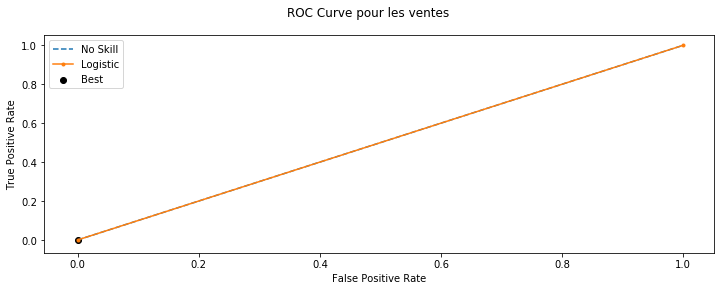

Best Threshold=1.000000, F-Score=0.925


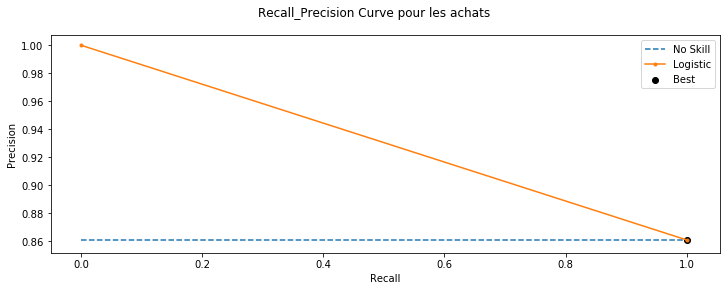

Best Threshold=1.000000, F-Score=0.925


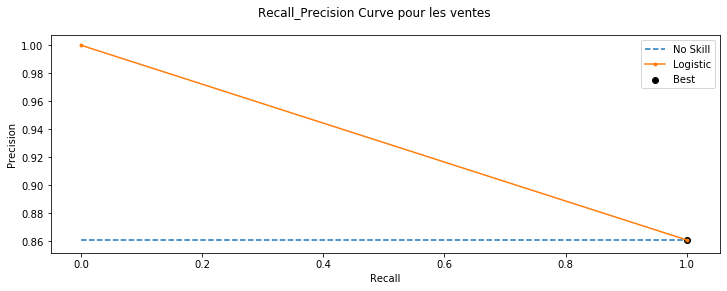

CPU times: user 1.52 s, sys: 84.1 ms, total: 1.61 s
Wall time: 4.95 s


In [24]:
%%time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
import colorama as col
from collections import Counter
import joblib

import pyttsx3
engine = pyttsx3.init()

import configparser
config = configparser.ConfigParser()

engine.say("Logistic Regression")
engine.runAndWait()

config.read('config.ini')
_period1 = config.get('TIMEFRAME','_period1')
_path4 = config.get('PATH','_path4')
_path5 = config.get('PATH','_path5')
_path = _path5
config['PATH']['_path'] = _path
with open('config.ini', 'w') as configfile: # save
    config.write(configfile)

x = 'EUR/USD'

df = pd.read_csv('Base_Signals/'+x.replace('/','')+'m5'+'.csv')

######

try:
    df = df.drop(['Unnamed: 0'],axis=1)
except:
    pass

### Isolation de la partie out of sample ####



df = df.iloc[:-int(len(df) * 0.2),:]
X = df.iloc[:,:-2]

Xb = df[df.Signal == 1]
Xb = Xb.set_index(Xb.Date, drop =True)
yb = Xb['BUY']
Xb = Xb.drop(['CloseBid','HigMax','LowMin','SELL','Date','Signal','BUY'],axis=1)
Xv = df[df.Signal == -1]
Xv = Xv.set_index(Xv.Date, drop =True)
yv = Xv['SELL']
Xv = Xv.drop(['CloseBid','HigMax','LowMin','BUY','Date','Signal','SELL'],axis=1)


# summarize class distribution
counterb = Counter(yb)
counterv = Counter(yv)
print('Signaux achat',counterb)
print('Signaux vente',counterv)

if counterb[0] > 2 and counterb[1] > 2 and counterv[0] > 2 and counterv[1] > 2:

    # split into train/test sets with same class ratio
    trainXb, testXb, trainyb, testyb = train_test_split(Xb, yb, test_size=0.7, stratify=yb)
    trainXv, testXv, trainyv, testyv = train_test_split(Xv, yv, test_size=0.7, stratify=yv)
    
    savename = 'JOBLIB/reglog/Save'+x.replace('/','')+'m5_buy.sav'
    model = joblib.load(savename)

    # fit model
    model.fit(trainXb, trainyb)
    # predict on test set
    yhatb = model.predict(testXb)
    # evaluate predictions
    print('Achat - Accuracy: %.3f' % accuracy_score(testyb, yhatb))
    print('Achat - Precision: %.3f' % precision_score(testyb, yhatb))
    print('Achat - Recall: %.3f' % recall_score(testyb, yhatb))
    print('Achat - F-measure: %.3f' % f1_score(testyb, yhatb))
    print('\n')
    print(classification_report(testyb, yhatb))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    print(confusion_matrix(testyb, yhatb))
    print('\n')
    
    savename = 'JOBLIB/reglog/Save'+x.replace('/','')+'m5_sell.sav'
    model = joblib.load(savename)

    model.fit(trainXv, trainyv)
    # predict on test set
    yhatv = model.predict(testXv)
    # evaluate predictions
    print('Vente - Accuracy: %.3f' % accuracy_score(testyv, yhatv))
    print('Vente - Precision: %.3f' % precision_score(testyv, yhatv))
    print('Vente - Recall: %.3f' % recall_score(testyv, yhatv))
    print('Vente - F-measure: %.3f' % f1_score(testyv, yhatv))
    print('\n')
    print(classification_report(testyv, yhatv))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    
    
    print(confusion_matrix(testyv, yhatv))
    print('\n')

    fprv, tprv, thresholdsv = roc_curve(testyv, yhatv)
    # calculate the g-mean for each threshold
    gmeansv = sqrt(tprv * (1-fprv))
    # locate the index of the largest g-mean
    ixv = argmax(gmeansv)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsv[ixv], gmeansv[ixv]))
    # plot the roc curve for the model
    plt.ion()
    plt.figure(figsize=(12,4))
    plt.suptitle('ROC Curve pour les ventes')
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fprv, tprv, marker='.', label='Logistic')
    plt.scatter(fprv[ixv], tprv[ixv], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

    precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
    # plot the roc curve for the model
    no_skillb= len(testyb[testyb==1]) / len(testyb)

    # convert to f score
    fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
    # locate the index of the largest f score
    ixb = argmax(fscoreb)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))

    plt.ion()
    plt.figure(figsize=(12,4))
    plt.suptitle('Recall_Precision Curve pour les achats')
    plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
    plt.plot(recallb, precisionb, marker='.', label='Logistic')
    plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

    precisionv, recallv, thresholdsv = precision_recall_curve(testyv, yhatv)
    # plot the roc curve for the model
    no_skillv= len(testyv[testyv==1]) / len(testyv)

    # convert to f score
    fscorev = (2 * precisionv * recallv) / (precisionv + recallv)
    # locate the index of the largest f score
    ixv = argmax(fscorev)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholdsv[ixv], fscorev[ixv]))

    plt.figure(figsize=(12,4))
    plt.suptitle('Recall_Precision Curve pour les ventes')
    plt.plot([0,1], [no_skillv,no_skillv], linestyle='--', label='No Skill')
    plt.plot(recallv, precisionv, marker='.', label='Logistic')
    plt.scatter(recallv[ixv], precisionv[ixv], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

else:
    print(col.Fore.RED,'Not enough populated for',col.Fore.YELLOW,x,col.Style.RESET_ALL)


In [25]:
accub = round(accuracy_score(testyb, yhatb) * 100,2)
precb = round(precision_score(testyb, yhatb) * 100,2)
recallb = round(recall_score(testyb, yhatb) * 100,2)
f1b = round(f1_score(testyb, yhatb) * 100,2)
print('Achat - Accuracy :' ,accub,'%')
print('Achat - Precision :',precb,'%')
print('Achat - Recall :', recallb,'%')
print('Achat - F-measure: :' ,f1b,'%')

Achat - Accuracy : 86.09 %
Achat - Precision : 86.09 %
Achat - Recall : 100.0 %
Achat - F-measure: : 92.53 %


In [26]:
accuv = round(accuracy_score(testyv, yhatv) * 100,2)
precv = round(precision_score(testyv, yhatv) * 100,2)
recallv = round(recall_score(testyv, yhatv) * 100,2)
f1v = round(f1_score(testyv, yhatv) * 100,2)
print('Vente - Accuracy :' ,accuv,'%')
print('Vente - Precision :',precv,'%')
print('Vente - Recall :', recallv,'%')
print('Vente - F-measure: :' ,f1v,'%')

Vente - Accuracy : 86.1 %
Vente - Precision : 86.1 %
Vente - Recall : 100.0 %
Vente - F-measure: : 92.53 %


In [27]:
#########################
### BT
####### 24 SEPT 20

In [28]:
import time

In [29]:
%%time
################# BACKTEST ##################
############################
######## LIBRAIRIES ########
############################
print('Importing Librairies...')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import colorama as col
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os
import datetime as dt
import numpy as np
from scraptickers import scrap_tickers
from setinputs import set_inputs
from generatesignals import gen_sig
import shelve
import talib
import statistics
import pyttsx3

engine = pyttsx3.init()

%matplotlib inline
plt.style.use('seaborn')
engine.say("librairie loaded")
engine.runAndWait()
print('Prêt')

scaler = MinMaxScaler(feature_range=(-1, 1))

import joblib

import pyttsx3
engine = pyttsx3.init()

import configparser
config = configparser.ConfigParser()

engine.say("Logistic Regression Backtest")
engine.runAndWait()

config.read('config.ini')
_period1 = config.get('TIMEFRAME','_period1') # 'm5'
_period2 = config.get('TIMEFRAME','_period2') # 'H1'
_period3 = config.get('TIMEFRAME','_period3') # 'D1'
_path1 = config.get('PATH','_path1') # 'Base/'
_path2 = config.get('PATH','_path2') # 'Base_Clean/'
_path3 = config.get('PATH','_path3') # 'Base_Input/'
_path4 = config.get('PATH','_path4') # 'Base_Signals/'
_path5 = config.get('PATH','_path5') # 'Base_bt/'
_path = _path3
config['PATH']['_path'] = _path

with open('config.ini', 'w') as configfile:    # save
    config.write(configfile)

TICKERS = scrap_tickers(_path)
config['TICKERS']['TICKERS'] = \
            str(TICKERS).replace("'",'').replace('[','').replace(']','').replace(',','').replace(' ',',')

with open('config.ini', 'w') as configfile:    # save
    config.write(configfile)

x = 'EUR/USD'
df = pd.read_csv('Base_Signals/'+x.replace('/','')+'m5'+'.csv')
start = pd.to_datetime(df.Date[0])

def convert(devise,_rate,_flag):
    
    prix_usd = 0
    if x[4:] == 'USD':
        prix_usd = devise
    elif x[:3] == 'USD':
        prix_usd = round(devise/_rate,2)
    elif _flag == 1:
        prix_usd = round(devise * _rate,2)
       
    elif _flag == -1 :
            prix_usd = round(devise / _rate,2)
    else:
        prix_usd = 'NA'
    return(prix_usd,_flag)

engine.say("functions initiated")
engine.runAndWait()
print('Functions initiated')
_number = 10000
_period = 'm5'
_period2 = 'D1'
_total = 0
_cash_ini = 200000
_cash = _cash_ini
_rate = 1
_flag = 0


Importing Librairies...
Importing Librairies...
Librairies imported

Prêt
Base_Input/
Functions initiated
CPU times: user 211 ms, sys: 36.9 ms, total: 248 ms
Wall time: 18.4 s


In [30]:
DATE = []
CONTRACT = []
OPEN_POZ = []
CLOSE_POZ = []
RATE_OPEN_POZ = []
RATE_CLOSE_POZ = []
PNL_LAT = []
PNL_REAL = []
TOTAL_OPEN = []
TOTAL_CLOSE = []
PRICE_BUY = []
PRICE_SELL = []
DER_POZ = []
TOTAL_PNL_LAT = []
TOTAL_PNL_REAL = []
___Author___='LumberJack Jyss'
print('Global Optimized LumberJack Environment Motor for FOR_EX\nLumberJack Jyss 5780(c)')
print(col.Fore.BLUE,'°0Oo_D.A.G._26_oO0°')
print(col.Fore.YELLOW,col.Back.BLUE,'--- Go!em STOCHASTIC ML augmented #v0.15 ---',col.Style.RESET_ALL)

print('')
engine.say(" Initialisation du Gaulem Stok, m l augmented")
engine.runAndWait()

Global Optimized LumberJack Environment Motor for FOR_EX
LumberJack Jyss 5780(c)
 °0Oo_D.A.G._26_oO0°
  --- Go!em STOCHASTIC ML augmented #v0.15 --- 



In [31]:
%%time
df_resultats = pd.DataFrame(index=['TimeFrame 1','TimeFrame2','Equity','Nbre Winners','Nbre Loosers','Average lenght of trade','Cumul pnl'])

engine.say("קדימה")
engine.runAndWait()

globals()['df1_%s' %x.replace('/','')] = pd.read_csv('Base_Clean/'+x.replace('/','')+'m5'+'.csv')

df = globals()['df1_%s' %x.replace('/','')].copy()
df = df.set_index(pd.to_datetime(df.Date))
df = df[df.index > start]

######

try:
    df = df.drop(['Unnamed: 0'],axis=1)
except:
    pass
try:
    df = df.drop(['Date'],axis=1)
except:
    pass

if x[4:] == 'USD':
    _rate = 1

elif x[:3] == 'USD':
    _rate = con.get_last_price(x).Bid
elif x[:3] != 'USD' and x[4:] != 'USD':
    try:
        _rate = pd.read_csv('Base_Clean/'+(x[4:]+'/USD').replace('/','')+'m5'+'.csv').CloseBid[-1]
        _flag = 1
    except:
        _rate = pd.read_csv('Base_Clean/'+('USD/'+x[4:]).replace('/','')+'m5'+'.csv').CloseBid[-1]
        _flag = -1
else:
    prix_usd = 'NA'

print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

df1 = df.copy()

_position = 0
_equity = 0
_nbtransactions = 0
backtest_graph = pd.DataFrame()
EQUITY = [_cash]
CASH = [_cash]
_winner = 0
_looser = 0
_index_entry = 0
TRADE_DURATION = []
_average_duration = 0
_size = 50000

PRICE_BUY = []
PRICE_SELL = []

_total = 0

_target = 0.0020
_sl = 0.0090
_spread_filter = 0.00050
_filtre_multipoz = 1 # En %
_filtre_multipoz = _filtre_multipoz/100

_open_buy = 0
_open_sell = 0


_t1 = dt.datetime.now()
print('Début des opérations => INPUTS')
#p=mp.Pool(os.cpu_count())
#p.map(set_inputs,TICKERS) ===> probleme MinMax scal_
#p.close()
#p.join()

df1['delta_MM21_MM34'] = (talib.EMA(df1.Close, timeperiod=21) - talib.EMA(df1.CloseBid, timeperiod=34)) #* 1000
df1['BOLUP'],df1['BOLMID'],df1['BOLLOW'] = talib.BBANDS(df1.CloseBid, timeperiod=252, nbdevup=2, nbdevdn=2, matype=0)
df1['delta_price_BOLLOW'] = (df1.CloseBid - df1.BOLLOW) #* 1000
df1['delta_price_BOLUP'] = (df1.CloseBid - df1.BOLUP) #* 1000
df1['delat_price_ATR'] = (((df1.CloseBid - df1.OpenBid)) - talib.ATR(df1.HighBid,df1.LowBid,df1.CloseBid,timeperiod=5)) #* 1000
df1['delta_high_low'] = (df1.HighBid - df1.LowBid) #* 1000
df1['delta_close_open'] = (df1.CloseBid - df1.OpenBid) #* 1000

df1['delta_MM21_MM34'] = scaler.fit_transform(df1[['delta_MM21_MM34']])
df1['delta_price_BOLLOW'] = scaler.fit_transform(df1[['delta_price_BOLLOW']])
df1['delta_price_BOLUP'] = scaler.fit_transform(df1[['delta_price_BOLUP']])
df1['delat_price_ATR'] = scaler.fit_transform(df1[['delat_price_ATR']])
df1['delta_high_low'] = scaler.fit_transform(df1[['delta_high_low']])
df1['delta_close_open'] = scaler.fit_transform(df1[['delta_close_open']])

df1 = df1.dropna()

print("\n\n ===> Création des inputs terminée. Tout est nettoyé et prêt à l'utilisation")
_t2 = dt.datetime.now()
print("Temps d'excution du module",str((_t2 - _t1)))

###### GEN SIGN ######

_t1 = dt.datetime.now()
print('Début des opérations de génératioh des signaux horodatée à',dt.datetime.now())

SIGNALS = []
SIGNALS = [0]*25


MM21 = talib.EMA(df1.Close, timeperiod=21)
rsi = talib.RSI(df1.Close, timeperiod=14)
rsi_high = 65
rsi_low = 35
upperband, middleband, lowerband = talib.BBANDS(df1.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
fastk, fastd = talib.STOCHRSI(df1.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
slowk, slowd = talib.STOCH(df1.High, df1.Low, df1.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)#STOCHASTIC

df1 = df1.drop(['OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk', 'CloseAsk',\
                'Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1)

for i in range(25,len(df1)):

    if slowk[i-1] > 80 and slowk[i-1] > slowd[i-1] and slowk[i] < slowd[i]:

        
        

        SIGNALS.append(-1)    

                        
    elif slowk[i-1] < 20 and slowk[i-1] < slowd[i-1] and slowk[i] > slowd[i]: 
        
        

        SIGNALS.append(1)
    
    else:
        SIGNALS.append(0)    

df1.loc[df1['HigMax'] <= df1['CloseBid'] * (1 + _target),'BUY'] = 1     
df1.loc[df1['HigMax'] > df1['CloseBid'] * (1 + _target),'BUY'] = 0
df1.loc[df1['LowMin'] >= df1['CloseBid'] * (1 - _target),'SELL'] = 1    
df1.loc[df1['LowMin'] < df1['CloseBid'] * (1 - _target),'SELL'] = 0
df1['Signal'] = SIGNALS
df1 = df1[df1.Signal != 0]
df1 = df1.drop(['CloseBid','HigMax','LowMin','SELL','Signal','BUY'],axis=1)
_t2 = dt.datetime.now()
print("Temps d'excution du module",str((_t2 - _t1)))



 Le rate du ticker EUR/USD est à  1 
Début des opérations => INPUTS


 ===> Création des inputs terminée. Tout est nettoyé et prêt à l'utilisation
Temps d'excution du module 0:00:00.699042
Début des opérations de génératioh des signaux horodatée à 2020-09-29 15:07:11.088810
Temps d'excution du module 0:00:46.628980
CPU times: user 48.2 s, sys: 800 ms, total: 49 s
Wall time: 52.4 s


In [32]:
df1.head()

,delta_MM21_MM34,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open
Date,,,,,,
2010-09-21 13:25:00,0.126463,-0.177299,0.373526,0.111833,-0.934489,-0.092552
2010-09-21 14:10:00,0.129517,-0.186482,0.355679,0.144706,-0.916185,-0.047055
2010-09-21 14:55:00,0.120571,-0.191730,0.345544,0.155664,-0.894027,-0.047055
2010-09-21 15:30:00,0.092704,-0.220713,0.319338,0.117312,-0.974952,-0.098161
2010-09-21 15:55:00,0.107220,-0.192198,0.345269,0.146137,-0.954721,-0.071985


In [33]:

savename = 'JOBLIB/reglog/Save'+x.replace('/','')+'m5_buy.sav'
model = joblib.load(savename)


In [34]:
model.predict_proba(df1)

array([[0.53252985, 0.46747015],
       [0.53521079, 0.46478921],
       [0.54285457, 0.45714543],
       ...,
       [0.45937809, 0.54062191],
       [0.44578735, 0.55421265],
       [0.45273497, 0.54726503]])

In [ ]:
####################@
#####################
#  13 OCT
###############
###############

# REPRISE SUR FICHIER BT

In [1]:
%%time
import pandas as pd
x = 'USD/CNH'
df = pd.read_csv('Base_Clean/'+x.replace('/','')+'m5.csv')

print(df.shape)
print('')

df = df.iloc[-int(len(df) * 0.2):,:]

df = df.set_index(df.Date,drop = True)
print(df.shape)
print('')
df.head()

(617747, 16)

(123549, 16)

CPU times: user 1.72 s, sys: 330 ms, total: 2.05 s
Wall time: 1.87 s


,Date,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Total,Open,High,Low,Close,HigMax,LowMin
Date,,,,,,,,,,,,,,,,
2019-01-11 03:50:00,2019-01-11 03:50:00,6.75535,6.75623,6.75385,6.75619,6.75576,6.75670,6.75435,6.75668,1082,6.755555,6.756465,6.754100,6.756435,6.75716,6.74438
2019-01-11 03:55:00,2019-01-11 03:55:00,6.75619,6.75631,6.75179,6.75359,6.75668,6.75683,6.75226,6.75398,1150,6.756435,6.756570,6.752025,6.753785,6.75716,6.74438
2019-01-11 04:00:00,2019-01-11 04:00:00,6.75359,6.75583,6.75294,6.75493,6.75398,6.75638,6.75346,6.75546,895,6.753785,6.756105,6.753200,6.755195,6.75716,6.74438
2019-01-11 04:05:00,2019-01-11 04:05:00,6.75493,6.75657,6.75489,6.75632,6.75546,6.75710,6.75543,6.75682,476,6.755195,6.756835,6.755160,6.756570,6.75716,6.74438
2019-01-11 04:10:00,2019-01-11 04:10:00,6.75632,6.75716,6.75575,6.75577,6.75682,6.75770,6.75624,6.75626,432,6.756570,6.757430,6.755995,6.756015,6.75716,6.74438


In [2]:
from sklearn.linear_model import LinearRegression
import colorama as col
import pandas as pd
import time
import os
import datetime as dt
import numpy as np
import shelve
import talib
import statistics
import pyttsx3
from sklearn.preprocessing import MinMaxScaler
import configparser

config = configparser.ConfigParser()

def set_inputs(df,x):
    _bar = 0
    print(col.Fore.BLUE,'Génération des inputs pour le ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    _bar += 1           
    df1 = df.copy()

    df1['delta_MM21_MM34'] = (talib.EMA(df1.Close, timeperiod=21) - talib.EMA(df1.CloseBid, timeperiod=34)) #* 1000
    df1['BOLUP'],df1['BOLMID'],df1['BOLLOW'] = talib.BBANDS(df1.CloseBid, timeperiod=252, nbdevup=2, nbdevdn=2, matype=0)
    df1['delta_price_BOLLOW'] = (df1.CloseBid - df1.BOLLOW) #* 1000
    df1['delta_price_BOLUP'] = (df1.CloseBid - df1.BOLUP) #* 1000
    df1['delat_price_ATR'] = (((df1.CloseBid - df1.OpenBid)) - talib.ATR(df1.HighBid,df1.LowBid,df1.CloseBid,timeperiod=5)) #* 1000
    df1['delta_high_low'] = (df1.HighBid - df1.LowBid) #* 1000
    df1['delta_close_open'] = (df1.CloseBid - df1.OpenBid) #* 1000

    #df1 = df1.drop(['Date','OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk', 'CloseAsk',\
     #               'Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1)

    df1['delta_MM21_MM34'] = scaler.fit_transform(df1[['delta_MM21_MM34']])
    df1['delta_price_BOLLOW'] = scaler.fit_transform(df1[['delta_price_BOLLOW']])
    df1['delta_price_BOLUP'] = scaler.fit_transform(df1[['delta_price_BOLUP']])
    df1['delat_price_ATR'] = scaler.fit_transform(df1[['delat_price_ATR']])
    df1['delta_high_low'] = scaler.fit_transform(df1[['delta_high_low']])
    df1['delta_close_open'] = scaler.fit_transform(df1[['delta_close_open']])

    df1 = df1.dropna()
    

    return(df1)


def gen_sig(df,x):
    SIGNALS = []
    SIGNALS = [0]*25
    print(col.Fore.BLUE,'Génération des signaux pour le ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)


    df1 = df.copy()

    MM21 = talib.EMA(df1.Close, timeperiod=21)
    rsi = talib.RSI(df1.Close, timeperiod=14)
    rsi_high = 65
    rsi_low = 35
    upperband, middleband, lowerband = talib.BBANDS(df1.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    fastk, fastd = talib.STOCHRSI(df1.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
    slowk, slowd = talib.STOCH(df1.High, df1.Low, df1.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)#STOCHASTIC
    
    #df1 = df1.drop(['OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk',\
     #               'Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1)

    df1 = df1.drop(['Date','OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk', 'CloseAsk',\
                    'Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1)

    for i in range(25,len(df1)):

        if slowk[i-1] > 80 and slowk[i-1] > slowd[i-1] and slowk[i] < slowd[i]: 
            

            SIGNALS.append(-1)

                            
        elif slowk[i-1] < 20 and slowk[i-1] < slowd[i-1] and slowk[i] > slowd[i]: 
         

            SIGNALS.append(1)
        
        else:
            SIGNALS.append(0)

 
    df1['Signal'] = SIGNALS
    df1 = df1[df1.Signal != 0]
    return(df1)

scaler = MinMaxScaler(feature_range=(-1, 1))


_t1 = dt.datetime.now()
print('Début des opérations horodatée à',dt.datetime.now())
df1 = set_inputs(df,x)
print("\n\n ===> Génération des signaux terminée. Tout est nettoyé et prêt à l'utilisation")
_t2 = dt.datetime.now()
print("Temps d'excution du module",str((_t2 - _t1)))

_t1 = dt.datetime.now()
print('Début des opérations horodatée à',dt.datetime.now())
df2 = gen_sig(df1,x)
print("\n\n ===> Génération des signaux terminée. Tout est nettoyé et prêt à l'utilisation")
_t2 = dt.datetime.now()
print("Temps d'excution du module",str((_t2 - _t1)))



Début des opérations horodatée à 2020-10-19 21:49:49.103867
 Génération des inputs pour le ticker  USD/CNH 


 ===> Génération des signaux terminée. Tout est nettoyé et prêt à l'utilisation
Temps d'excution du module 0:00:00.164484
Début des opérations horodatée à 2020-10-19 21:49:49.268488
 Génération des signaux pour le ticker  USD/CNH 


 ===> Génération des signaux terminée. Tout est nettoyé et prêt à l'utilisation
Temps d'excution du module 0:00:05.161294


In [3]:
df1.shape

(123275, 25)

In [4]:
df1.head()

,Date,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Total,...,LowMin,delta_MM21_MM34,BOLUP,BOLMID,BOLLOW,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-13 22:55:00,2019-01-13 22:55:00,6.76363,6.76371,6.76083,6.76115,6.76818,6.76818,6.76718,6.76722,23,...,6.76150,0.046885,6.771724,6.755676,6.739629,-0.249756,0.133120,0.096233,-0.904096,-0.124056
2019-01-13 23:00:00,2019-01-13 23:00:00,6.76115,6.76219,6.76115,6.76175,6.76722,6.76758,6.76646,6.76649,484,...,6.76150,0.046515,6.771764,6.755698,6.739633,-0.245092,0.137638,0.153584,-0.965368,-0.068680
2019-01-13 23:05:00,2019-01-13 23:05:00,6.76175,6.76194,6.75956,6.75972,6.76649,6.76649,6.76442,6.76447,399,...,6.76150,0.041521,6.771794,6.755722,6.739651,-0.261124,0.121015,0.103594,-0.920746,-0.115965
2019-01-13 23:10:00,2019-01-13 23:10:00,6.75972,6.76064,6.75929,6.75969,6.76447,6.76480,6.76275,6.76353,284,...,6.75996,0.034253,6.771820,6.755741,6.739663,-0.261448,0.120560,0.140663,-0.955045,-0.080007
2019-01-13 23:15:00,2019-01-13 23:15:00,6.75969,6.76183,6.75924,6.76150,6.76353,6.76452,6.76220,6.76395,1451,...,6.75996,0.027525,6.771857,6.755762,6.739667,-0.247318,0.134870,0.170175,-0.913753,-0.046926


In [5]:
df2.shape

(11923, 10)

In [6]:
df2.head()

,CloseBid,HigMax,LowMin,delta_MM21_MM34,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open,Signal
Date,,,,,,,,,,
2019-01-14 01:25:00,6.75449,6.76361,6.73964,-0.135026,-0.312537,0.067089,0.130408,-0.935398,-0.066343,1
2019-01-14 01:45:00,6.74534,6.76361,6.74063,-0.254205,-0.380350,-0.008067,0.166185,-0.783217,0.023013,1
2019-01-14 03:00:00,6.75648,6.76532,6.75646,-0.222899,-0.288413,0.080232,0.055519,-0.892774,-0.124236,-1
2019-01-14 04:30:00,6.75921,6.77147,6.75928,-0.089377,-0.283425,0.103039,0.150826,-0.965701,-0.072636,1
2019-01-14 05:05:00,6.76546,6.77643,6.76033,-0.051577,-0.248951,0.157405,0.136881,-0.973027,-0.085041,-1


In [7]:
df2 = df2[df2.Signal == 1]
print(df2.shape)
df2.head()

(5934, 10)


,CloseBid,HigMax,LowMin,delta_MM21_MM34,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open,Signal
Date,,,,,,,,,,
2019-01-14 01:25:00,6.75449,6.76361,6.73964,-0.135026,-0.312537,0.067089,0.130408,-0.935398,-0.066343,1
2019-01-14 01:45:00,6.74534,6.76361,6.74063,-0.254205,-0.380350,-0.008067,0.166185,-0.783217,0.023013,1
2019-01-14 04:30:00,6.75921,6.77147,6.75928,-0.089377,-0.283425,0.103039,0.150826,-0.965701,-0.072636,1
2019-01-14 05:35:00,6.76403,6.77643,6.76033,-0.056422,-0.273594,0.150451,0.157618,-0.932401,-0.065264,1
2019-01-14 07:50:00,6.77009,6.77255,6.76393,-0.036610,-0.262139,0.196141,0.137364,-0.945055,-0.070298,1


In [8]:
import joblib

savename = 'JOBLIB/reglog_imbal/Save'+x.replace('/','')+'m5_buy.sav'
        
loaded_model = joblib.load(savename)

df2['BUY'] = loaded_model.predict(df2.drop(['CloseBid','HigMax','LowMin'],axis=1))


In [9]:
df2.BUY.sum()

5663.0

In [10]:
savename = 'JOBLIB/reglog_imbal/Save'+x.replace('/','')+'m5_sell.sav'
        
loaded_model = joblib.load(savename)

df2['SELL'] = loaded_model.predict(df2.drop(['CloseBid','HigMax','LowMin','BUY'],axis=1))

df2

,CloseBid,HigMax,LowMin,delta_MM21_MM34,delta_price_BOLLOW,delta_price_BOLUP,delat_price_ATR,delta_high_low,delta_close_open,Signal,BUY,SELL
Date,,,,,,,,,,,,
2019-01-14 01:25:00,6.75449,6.76361,6.73964,-0.135026,-0.312537,0.067089,0.130408,-0.935398,-0.066343,1,1.0,1.0
2019-01-14 01:45:00,6.74534,6.76361,6.74063,-0.254205,-0.380350,-0.008067,0.166185,-0.783217,0.023013,1,1.0,0.0
2019-01-14 04:30:00,6.75921,6.77147,6.75928,-0.089377,-0.283425,0.103039,0.150826,-0.965701,-0.072636,1,1.0,1.0
2019-01-14 05:35:00,6.76403,6.77643,6.76033,-0.056422,-0.273594,0.150451,0.157618,-0.932401,-0.065264,1,1.0,1.0
2019-01-14 07:50:00,6.77009,6.77255,6.76393,-0.036610,-0.262139,0.196141,0.137364,-0.945055,-0.070298,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-04 18:50:00,6.83589,6.83749,6.83547,-0.216260,-0.434606,0.115901,0.170170,-0.959707,-0.064006,1,1.0,1.0
2020-09-04 19:35:00,6.83546,6.83762,6.83547,-0.203345,-0.430689,0.109547,0.155193,-0.978355,-0.077850,1,1.0,1.0
2020-09-04 20:20:00,6.83523,6.83762,6.83565,-0.191698,-0.424909,0.105476,0.167996,-0.986680,-0.075153,1,1.0,1.0


In [11]:
x

'USD/CNH'

In [1]:
########################
######################
####### 20 OCTOBRE
####

In [1]:
import pandas as pd
import time
import joblib
import colorama as col
from sklearn.preprocessing import MinMaxScaler
import talib

scaler = MinMaxScaler(feature_range=(-1, 1))


In [7]:
DATE = []
CONTRACT = []
OPEN_POZ = []
CLOSE_POZ = []
RATE_OPEN_POZ = []
RATE_CLOSE_POZ = []
PNL_LAT = []
PNL_REAL = []
TOTAL_OPEN = []
TOTAL_CLOSE = []
PRICE_BUY = []
PRICE_SELL = []
DER_POZ = []
TOTAL_PNL_LAT = []
TOTAL_PNL_REAL = []
_cash_ini = 50000
_cash = _cash_ini
_target = 0.0040
_sl = 0.0040
_period = 'm5'
_period2 = 'H1'
_period3 = 'D1'

In [8]:
%%time

TICKERS = ['EUR/USD','USD/JPY','GBP/USD'] #,'USD/CHF','EUR/CHF' ,'AUD/USD','USD/CAD','NZD/USD','EUR/GBP','EUR/JPY','GBP/JPY','CHF/JPY','GBP/CHF','EUR/AUD','EUR/CAD','AUD/CAD','AUD/JPY','CAD/JPY','NZD/JPY','GBP/CAD','GBP/NZD','GBP/AUD','AUD/NZD','USD/SEK','EUR/SEK','EUR/NOK','USD/NOK','USD/MXN','AUD/CHF','EUR/NZD','USD/ZAR','ZAR/JPY','NZD/CHF','CAD/CHF','NZD/CAD','USD/ILS','USD/CNH']

equity = 100000
for x in TICKERS:
    print(col.Fore.BLUE+'Backtest pour le ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)

    '''df = pd.read_csv('Base_Signals/'+x.replace('/','')+'m5.csv')
    try:
        df = df.drop(['Unnamed: 0'],axis=1)
    except:
        pass

    df = df.iloc[-int(len(df) * 0.2):,:]'''

    df_resultats = pd.DataFrame(index=['TimeFrame 1','TimeFrame2','Equity','Nbre Winners','Nbre Loosers','Average lenght of trade','Cumul pnl'])
    price = pd.read_csv('Base_Clean/'+x.replace('/','')+'m5'+'.csv')
    price = price.iloc[-int(len(price) * 0.2):,:]
    price['Close'] = (price.CloseBid + price.CloseAsk)/2
    price['High'] = (price.HighBid + price.HighAsk)/2
    price['Low'] = (price.LowBid + price.LowAsk)/2
    price['Open'] = (price.OpenBid + price.OpenAsk)/2

    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()
    EQUITY = [_cash]
    CASH = [_cash]
    _winner = 0
    _looser = 0
    _index_entry = 0
    TRADE_DURATION = []
    _average_duration = 0
    _size = 50000

    PRICE_BUY = []
    PRICE_SELL = []

    _total = 0

    _filtre_multipoz = 0.2 # En %
    _filtre_multipoz = _filtre_multipoz/100
    
    _open_buy = 0
    _open_sell = 0
    _minipoz = 0

    MM21 = talib.EMA(price.Close, timeperiod=21)
    MM50 = talib.EMA(price.Close, timeperiod=50)
    MM200 = talib.EMA(price.Close, timeperiod=200)
    rsi = talib.RSI(price.Close, timeperiod=14)
    rsi_high = 70
    rsi_low = 30
    upperband, middleband, lowerband = talib.BBANDS(price.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    fastk, fastd = talib.STOCHRSI(price.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
    slowk, slowd = talib.STOCH(price.High, price.Low, price.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)#STOCHASTIC


    savenameb = 'JOBLIB/reglog_imbal/Save'+x.replace('/','')+'m5_buy.sav'
    savenamev = 'JOBLIB/reglog_imbal/Save'+x.replace('/','')+'m5_sell.sav'

    loaded_modelb = joblib.load(savenameb)
    loaded_modelv = joblib.load(savenamev)

    price['delta_MM21_MM34'] = (talib.EMA(price.Close, timeperiod=21) - talib.EMA(price.CloseBid, timeperiod=34)) #* 1000
    price['BOLUP'],price['BOLMID'],price['BOLLOW'] = talib.BBANDS(price.CloseBid, timeperiod=252, nbdevup=2, nbdevdn=2, matype=0)
    price['delta_price_BOLLOW'] = (price.CloseBid - price.BOLLOW) #* 1000
    price['delta_price_BOLUP'] = (price.CloseBid - price.BOLUP) #* 1000
    price['delat_price_ATR'] = (((price.CloseBid - price.OpenBid)) - talib.ATR(price.HighBid,price.LowBid,price.CloseBid,timeperiod=5)) #* 1000
    price['delta_high_low'] = (price.HighBid - price.LowBid) #* 1000
    price['delta_close_open'] = (price.CloseBid - price.OpenBid) #* 1000

    #df1 = df1.drop(['OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk', 'CloseAsk',\
        #               'Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1)

    price['delta_MM21_MM34'] = scaler.fit_transform(price[['delta_MM21_MM34']])
    price['delta_price_BOLLOW'] = scaler.fit_transform(price[['delta_price_BOLLOW']])
    price['delta_price_BOLUP'] = scaler.fit_transform(price[['delta_price_BOLUP']])
    price['delat_price_ATR'] = scaler.fit_transform(price[['delat_price_ATR']])
    price['delta_high_low'] = scaler.fit_transform(price[['delta_high_low']])
    price['delta_close_open'] = scaler.fit_transform(price[['delta_close_open']])

    price = price.dropna()
    price['BUY'] = loaded_modelb.predict(price.drop(['OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk',\
        'Date','CloseBid','HigMax','LowMin','Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW'],axis=1))
    price['SELL'] = loaded_modelv.predict(price.drop(['OpenBid', 'HighBid', 'LowBid', 'OpenAsk', 'HighAsk', 'LowAsk',\
        'Date','CloseAsk','HigMax','LowMin','Total', 'Open', 'High', 'Low', 'Close', 'BOLUP', 'BOLMID', 'BOLLOW','BUY'],axis=1))

    

    for i in range(len(price)):
        if _position == 0 :
            if slowk.values[i-1] > 80 and slowk.values[i-1] > slowd.values[i-1] and slowk.values[i] < slowd.values[i] and \
                price.iloc[i-1]['High'] > price.iloc[i-2]['High'] and price.iloc[i]['High'] < price.iloc[i-2]['High'] and \
                    price.iloc[i]['SELL'] == 1:

                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                print('\nLe ',price.Date.iloc[i],'Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')
                print('Nouvelle moyenne du price_sell',_price_sell_mean)

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)

                TOTAL_OPEN.append(1)

            elif slowk.values[i-1] < 20 and slowk.values[i-1] < slowd.values[i-1] and slowk.values[i] > slowd.values[i] \
                and price.iloc[i-1]['Low'] < price.iloc[i-2]['Low'] and price.iloc[i]['Low'] > price.iloc[i-2]['Low'] \
                    and price.iloc[i]['BUY'] == 1:
                    
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                print('\nLe ',price.Date.iloc[i],'Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')
                print('Nouvelle moyenne du price_buy',_price_buy_mean)

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0) 

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
        elif _position == 1:

            if slowk.values[i-1] < 20 and slowk.values[i-1] < slowd.values[i-1] and slowk.values[i] > slowd.values[i]\
                and price.iloc[i-1]['Low'] < price.iloc[i-2]['Low'] and price.iloc[i]['Low'] > price.iloc[i-2]['Low']\
                    and price.iloc[i]['BUY'] == 1\
                        and (price_buy - price.Close.iloc[i]) / price_buy >= _filtre_multipoz :

                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                print('\nLe ',price.Date.iloc[i],'Position',_open_buy,'bought at ', price_buy,'(verification liste',PRICE_BUY[-1],')')
                print(col.Fore.YELLOW,'Nouvelle',col.Style.RESET_ALL, 'moyenne du price_buy',_price_buy_mean)

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
            
            elif (float(price.CloseBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target :

                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy
                # _pnl,_flag = convert(_pnl,_rate,_flag)
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                CASH.append(_cash)
                _winner += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                print(i)
                print(col.Fore.GREEN,'\nLe ',price.Date.iloc[i],' ',_open_buy,'positions TP closed at',price.CloseBid.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)
                print(col.Fore.BLUE,'__________________________________________________________________________________',col.Style.RESET_ALL)
                print('')

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy)
                PRICE_BUY = [] 
                _open_buy = 0

            elif (float(price.CloseBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) <= -_sl :

                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy
                # _pnl,_flag = convert(_pnl,_rate,_flag)
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                CASH.append(_cash)
                _looser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                print(i)
                print(col.Fore.RED,'\nLe ',price.Date.iloc[i],' ',_open_buy,'positions SL closed at',price.CloseBid.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)
                print(col.Fore.BLUE,'__________________________________________________________________________________',col.Style.RESET_ALL)
                print('')

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0

            else:
                    
                    _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy
                    # _pnl,_flag = convert(_pnl,_rate,_flag)
                    _equity = _cash + _pnl
                    EQUITY.append(_equity)
                    CASH.append(_cash)

                    DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                    CONTRACT.append(x)
                    OPEN_POZ.append(0)
                    CLOSE_POZ.append(0)
                    RATE_OPEN_POZ.append(0)
                    RATE_CLOSE_POZ.append(0) ############### 
                    PNL_LAT.append(_pnl)
                    PNL_REAL.append(0)
                    TOTAL_PNL_LAT.append(_pnl)
                    TOTAL_PNL_REAL.append(0) 


        elif _position == -1:

            if slowk.values[i-1] > 80 and slowk.values[i-1] > slowd.values[i-1] and slowk.values[i] < slowd.values[i] \
                and price.iloc[i-1]['High'] > price.iloc[i-2]['High'] and price.iloc[i]['High'] < price.iloc[i-2]['High'] \
                    and price.iloc[i]['SELL'] == 1\
                        and ( price.Close.iloc[i] - price_sell) / price_sell >= _filtre_multipoz :

                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = -1
                _index_entry = i
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                print('\nLe ',price.Date.iloc[i],'Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')
                print(col.Fore.YELLOW,'Nouvelle',col.Style.RESET_ALL, 'moyenne du price_sell',_price_sell_mean)

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0) 



            elif (float(price.CloseAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target :

                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell
                # _pnl,_flag = convert(_pnl,_rate,_flag)
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                CASH.append(_cash)
                _winner += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                print(col.Fore.GREEN,'\nLe ',price.Date.iloc[i],' ',_open_sell,'positions TP closed at',price.CloseAsk.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)
                print(col.Fore.BLUE,'__________________________________________________________________________________',col.Style.RESET_ALL)
                print('')

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = [] 
                _open_sell = 0

            elif (float(price.CloseAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) >= _sl :
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell
                # _pnl,_flag = convert(_pnl,_rate,_flag)
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                CASH.append(_cash)
                _looser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                print(i)
                print(col.Fore.RED,'\nLe ',price.Date.iloc[i],' ',_open_sell,'position SL closed at',price.CloseAsk.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)
                print(col.Fore.BLUE,'__________________________________________________________________________________',col.Style.RESET_ALL)
                print('')

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0

            else:
                
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell
                # _pnl,_flag = convert(_pnl,_rate,_flag)
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)

                TOTAL_PNL_REAL.append(0)
                                                
        #elif i == (len(price)-1) and _position != 0 :

    if _position == -1:
        _position = 0
        _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell
        # _pnl,_flag = convert(_pnl,_rate,_flag)
        _total += _pnl
        _cash += _pnl
        _equity = _cash
        EQUITY.append(_equity)
        CASH.append(_cash)
        _looser += _open_sell
        TRADE_DURATION.append(i - _index_entry)
        print(col.Fore.CYAN,"\nCloture des positions en l'air",col.Style.RESET_ALL)
        print(col.Fore.RED,'\nLe ',price.Date.iloc[i],' ',_open_sell,'position closed at',price.CloseAsk.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
        print('nombre de candles en position :',i - _index_entry)
        print('Equity :', _equity)

        DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
        CONTRACT.append(x)
        OPEN_POZ.append(0)
        CLOSE_POZ.append(-1)
        RATE_OPEN_POZ.append(0)
        RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
        PNL_LAT.append(0)
        PNL_REAL.append(_pnl)
        TOTAL_PNL_LAT.append(0)
        TOTAL_PNL_REAL.append(_pnl)
        TOTAL_CLOSE.append(_open_sell)
        PRICE_SELL = []
        _open_sell = 0

    if _position == 1:

        _position = 0
        _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy
        # _pnl,_flag = convert(_pnl,_rate,_flag)
        _total += _pnl
        _cash += _pnl
        _equity = _cash
        EQUITY.append(_equity)
        CASH.append(_cash)
        _looser += _open_buy

        TRADE_DURATION.append(i - _index_entry)
        print(col.Fore.CYAN,"\nCloture des positions en l'air",col.Style.RESET_ALL)
        print(col.Fore.RED,'\nLe ',price.Date.iloc[i],' ',_open_buy,'positions closed at',price.CloseBid.iloc[i],'pnl', _pnl,col.Style.RESET_ALL)
        print('nombre de candles en position :',i - _index_entry)
        print('Equity :', _equity)

        DATE.append(price.Date.iloc[i])# .strftime(format='%Y-%m-%d %H:%M:%S'))
        CONTRACT.append(x)
        OPEN_POZ.append(0)
        CLOSE_POZ.append(1)
        RATE_OPEN_POZ.append(0)
        RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
        PNL_LAT.append(0)
        PNL_REAL.append(_pnl)
        TOTAL_CLOSE.append(_open_buy) 
        TOTAL_PNL_LAT.append(0)
        TOTAL_PNL_REAL.append(_pnl)
        PRICE_BUY = []
        _open_buy = 0
    
    print(col.Fore.BLUE+'\nSynthèse pour le ticker\n',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    try:
        _average_duration = round(statistics.mean(TRADE_DURATION),2)

    except:
        print("(pas de duration)") 
        _average_duration = 'NA'               
    print(col.Fore.MAGENTA,"\nLes gains faramineux s'élèvent à : $",col.Fore.GREEN,round(_total,2),'! En ',_nbtransactions,' transactions.',col.Style.RESET_ALL ) 
    print(col.Fore.GREEN,"\nNbre de winners :",_winner,col.Style.RESET_ALL)
    print(col.Fore.RED,"\nNbre de loosers :",_looser,col.Style.RESET_ALL)
    print("\nAverage trade duration ",_average_duration)
    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [_period,_period2,(round(_equity,2)),(_winner),(_looser),(_average_duration),(_total)]

    print('Total des gains faramineux :',round(EQUITY[-1] - _cash_ini,2))
    print('Pnl latent restant',_pnl,'Open Buy',_open_buy,'Open Sell',_open_sell)
    DER_POZ.append(_pnl)

print(col.Fore.BLUE,'Total des gains faramineux :',round(EQUITY[-1] - _cash_ini,2),col.Style.RESET_ALL)
print(col.Fore.YELLOW,'Total du cash titanesque :',round(EQUITY[-1],2),col.Style.RESET_ALL)

df_historical = pd.DataFrame()
df_historical = pd.DataFrame(index=DATE)
df_historical['Contract'] = CONTRACT
df_historical['Open_Poz'] = OPEN_POZ
df_historical['Close_Pos'] = CLOSE_POZ
df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
df_historical['Pnl_Real'] = TOTAL_PNL_REAL
df_historical.sort_index()
df_historical


print('Cash généré :',str(round(df_historical.Pnl_Real.sum(),2))+'$')
print('Pnl latent minimal :',str(df_historical.Pnl_Real.min())+'$')
print('Pnl latent maximal :',str(df_historical.Pnl_Real.max())+'$')
print('Pnl latent moyen :',str(round(df_historical.Pnl_Real.mean(),2))+'$')
print('Max des durées moyennes',df_resultats.T['Average lenght of trade'][df_resultats.T['Average lenght of trade'] != 'NA'].max())
print('Min des durées moyennes',df_resultats.T['Average lenght of trade'][df_resultats.T['Average lenght of trade'] != 'NA'].min())
print('Moyenne des durées moyennes',round(df_resultats.T['Average lenght of trade'][df_resultats.T['Average lenght of trade'] != 'NA'].mean(),2))
print('Nombre total de winners',df_resultats.T['Nbre Winners'].sum())
print('Nombre total de loosers',df_resultats.T['Nbre Loosers'].sum())
print('Total des gains cumulés',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
print('Total des pertes cumulées',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
print(col.Fore.BLUE,'PROFIT FACTOR : ',\
    abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
print(col.Fore.CYAN,'Ratio du nombre de winners :',\
    round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),'%',col.Style.RESET_ALL)
print('Nombre total de trades ouverts',sum(TOTAL_OPEN))
print('Nombre total de trades fermés',sum(TOTAL_CLOSE))
print("Nombre de positions en l'air",(sum(TOTAL_OPEN) - sum(TOTAL_CLOSE)))

Backtest pour le ticker  EUR/USD 

Le  2018-09-10 08:00:00 Position 1 bought at 1.15658 (verification liste 1.15658 )
Nouvelle moyenne du price_buy 1.15658
1014
 
Le  2018-09-11 06:00:00   1 positions TP closed at 1.16134 pnl 238.0000000000049 
nombre de candles en position : 264
Equity : 50238.00000000001
 __________________________________________________________________________________ 


Le  2018-09-12 15:15:00 Position 1 bought at 1.16472 (verification liste 1.16472 )
Nouvelle moyenne du price_buy 1.16472
1681
 
Le  2018-09-13 13:35:00   1 positions TP closed at 1.1695799999999998 pnl 242.99999999999324 
nombre de candles en position : 268
Equity : 50481.0
 __________________________________________________________________________________ 


Le  2018-09-14 08:45:00 Position 1 sold at 1.17031 (verification liste 1.17031 )
Nouvelle moyenne du price_sell 1.17031
 
Le  2018-09-14 15:55:00   1 positions TP closed at 1.16561 pnl 234.99999999999633 
nombre de candles en position : 86
Equ

In [1]:
# Créer inpunt => Signal => Reglog

In [1]:
from sklearn.linear_model import LinearRegression
import colorama as col
import pandas as pd
import time
import os
import datetime as dt
import numpy as np
import shelve
import talib
import statistics
import pyttsx3
import configparser
from scipy.signal import argrelextrema


In [20]:
%%time
df = pd.read_csv('Base_Clean/EURUSDm5.csv')

CPU times: user 1.67 s, sys: 184 ms, total: 1.86 s
Wall time: 1.87 s


In [21]:
df.head(0)

,Date,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Total,Open,High,Low,Close,HigMax,LowMin


In [22]:
%%time
order = 10
df['ExtremCloseBid'] = 0
df['ExtremCloseBid'].loc[argrelextrema(df.values,np.greater,order=order)[0]] = 1
df['ExtremCloseBid'].loc[argrelextrema(df.values,np.less,order=order)[0]] = -1


CPU times: user 32.4 s, sys: 1.79 s, total: 34.2 s
Wall time: 34.6 s


In [24]:
def peak_detect(price,order=10):
    max_idx = list(argrelextrema(price,np.greater,order=order)[0])
    min_idx = list(argrelextrema(price,np.less,order=order)[0])
    idx = max_idx + min_idx + [len(price)-1]
    idx.sort()
    current_idx = idx[-3:]
    
    start = min(current_idx)
    end = max(current_idx)
    current_pat = price[current_idx]
    return (current_idx,current_pat,start,end)

def retracement():
    XA=moves[0]
    AB=moves[1]
    X=prices[0]
    A=prices[1]
    B=prices[2]
    AB_range = np.array([0.618 - err_allowed,0.618+ err_allowed])*abs(XA)
    #AB_range2 = np.array([0.618 - err_allowed,0.618+ err_allowed])*abs(XA)
    if abs(A-X)/X>0.002:
        if XA>0 and AB<0 :
            if (AB_range[0]<abs(AB)<AB_range[1]) : #or (AB_range2[0]<abs(AB)<AB_range2[1]) :
                _retrace = 1
                return (_retrace)
            else:
                return (np.isnan)
        elif XA<0 and AB>0 :
            if (AB_range[0]<abs(AB)<AB_range[1]) : #or (AB_range2[0]<abs(AB)<AB_range2[1]):
                _retrace = -1
                return (_retrace)
            else:
                return (np.isnan)
        else:
             return (np.isnan)
    return()

price = df.CloseBid

In [26]:
%%time
for i in range(200,len(price)):

    current_idx,current_pat,start,end = peak_detect(price.values,order=10)
    _retrace = retracement()


NameError: name 'moves' is not defined

In [195]:
df = pd.DataFrame()
order = 10
df['Val'] = [5,1,2,3,5,7,2,4,6,2,8,3,5,1,2,3,5,1,2,3,5,7,2,4,6,2,8,7,2,4,6,21,8,4,36,9,1,2,3,5,1,2,3,5,7,2,2,4,6,0,8,7,2,4,6,2,8,4,6,9,1,2,3,15,1,4,6,2,8,7,1,2,3,5,7,2,4,6,2,8,2,4,6,2,8,20,18,4,3,21]
df.shape

(90, 1)

In [196]:
argrelextrema(df.values,np.greater,order=order),argrelextrema(df.values,np.less,order=order)

((array([10, 34, 63]), array([0, 0, 0])), (array([ 1, 49]), array([0, 0])))

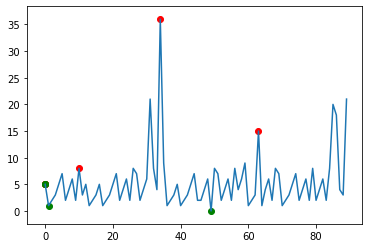

In [197]:
from matplotlib import pyplot as plt
plt.plot(df)
for i in argrelextrema(df.values,np.greater,order=order):
    plt.scatter(x=[i],y=df.iloc[i],c="r")
for i in argrelextrema(df.values,np.less,order=order):
    plt.scatter(x=[i],y=df.iloc[i],c="g")

In [198]:
df['Extrem'] = 0
df['Extrem'].loc[argrelextrema(df.values,np.greater,order=order)[0]] = 1
df['Extrem'].loc[argrelextrema(df.values,np.less,order=order)[0]] = -1

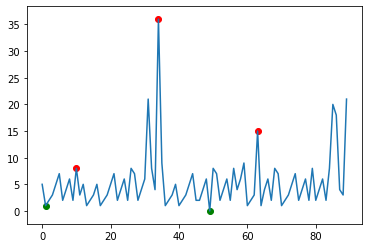

In [199]:
plt.plot(df['Val'])
for i in df[df['Extrem'] == 1].index:
    plt.scatter(x=i,y=df.iloc[i]['Val'],c='r')
for i in df[df['Extrem'] == -1].index:
    plt.scatter(x=i,y=df.iloc[i]['Val'],c='g')
